In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'Conv_VAE_log_results'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

In [3]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
with torch.cuda.device(0):
    train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)
    fixed_z = torch.randn((50, 2))
    fixed_data, _ = next(iter(test_loader))

In [4]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(*size, padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [5]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(*size, padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [6]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else:
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [9]:
class Net(nn.Module):
    def __init__(self, latent_size=10, gamma=1e-3, batchnorm=False, dropout=False, optim_type='Adam', **optim_params):
        super(Net, self).__init__()
    
        self.latent_size = latent_size
        self.gamma = gamma
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, pool_layer=None)
            
        self.fce = FullyConnected([32*2*2, latent_size*2])
        self.fcd = FullyConnected([latent_size, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self._loss = None
        if optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        h = self.fce(flatten)
        self.mu, self.logvar = h.split(self.latent_size, dim=1)
        return self.mu, self.logvar
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        if self.training:
            std = logvar.mul(0.5).exp()
            h = self._sample(mu.shape[0]) * std + mu
        else:
            h = mu
        x = self.decode(h)
        return x
    
    def _sample(self, n):
        with torch.cuda.device(0):
            return torch.randn([n, self.latent_size])
    
    def loss(self, output, target, size_average=True):
        KLD = self.mu ** 2 + self.logvar.exp() - 1 - self.logvar
        KLD = 0.5*KLD.sum(1)
        if size_average:
            self.KLD = KLD.mean()
        else:
            self.KLD = KLD.sum()
        self._loss = F.mse_loss(output, target, size_average=size_average)
        
        return self._loss + self.gamma * self.KLD

In [10]:
models = {'VAE2': Net(2, 0.005, batchnorm=True, lr=1e-4)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [11]:
def train(epoch, models, log=None):
    with torch.cuda.device(0):
        train_size = len(train_loader.sampler)
        for batch_idx, (data, _) in enumerate(train_loader):
            for model in models.values():
                model.optim.zero_grad()
                output = model(data)
                loss = model.loss(output, data)
                loss.backward()
                model.optim.step()

            if batch_idx % 200 == 0:
                line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                    epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
                losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
                print(line + losses)

        else:
            batch_idx += 1
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            if log is not None:
                for k in models:
                    log[k].append((models[k]._loss,))
            print(line + losses)

In [12]:
def test(models, loader, epoch, log=None):
    with torch.cuda.device(0):
        test_size = len(loader)
        test_reconstruction_loss = {k: 0. for k in models}
        test_KL_loss = {k: 0. for k in models}
        with torch.no_grad():
            for data, _ in loader:
                output = {k: m(data) for k, m in models.items()}
                for k, m in models.items():
                    m.loss(output[k], data)
                    test_reconstruction_loss[k] += m._loss.item()
                    test_KL_loss[k] += m.KLD.item()

        for k in models:
            test_reconstruction_loss[k] /= test_size
            test_KL_loss[k] /= test_size
        report = 'Test losses: ' + ' '.join(['{}: {:.4f}/{:.4f}'.format(k, 
                                                                        test_reconstruction_loss[k], 
                                                                        test_KL_loss[k]) for k in models])
        for k in models:
            if log is not None:
                log[k].append((test_reconstruction_loss[k], test_KL_loss[k]))
            with torch.no_grad():
                ae_data = models[k](fixed_data).data.numpy()
                fixed_gen = models[k].decode(fixed_z).data.numpy()
                plot_mnist(ae_data, (5, 10), True, AE_folder + '/%s_%03d.png' % (k, epoch))
                plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
        print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses VAE2: 0.9581
Train Epoch: 1 [10000/50000 (20%)]	Losses VAE2: 0.8077
Train Epoch: 1 [20000/50000 (40%)]	Losses VAE2: 0.7635
Train Epoch: 1 [30000/50000 (60%)]	Losses VAE2: 0.7261
Train Epoch: 1 [40000/50000 (80%)]	Losses VAE2: 0.6759
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE2: 0.6496


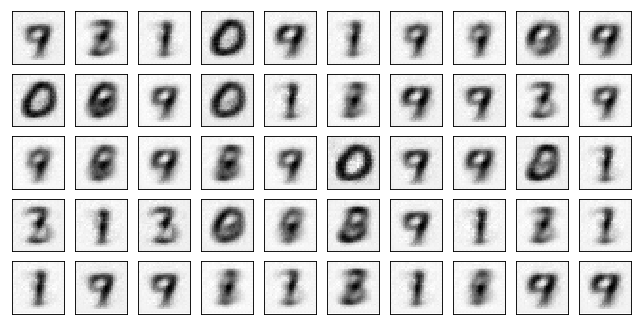

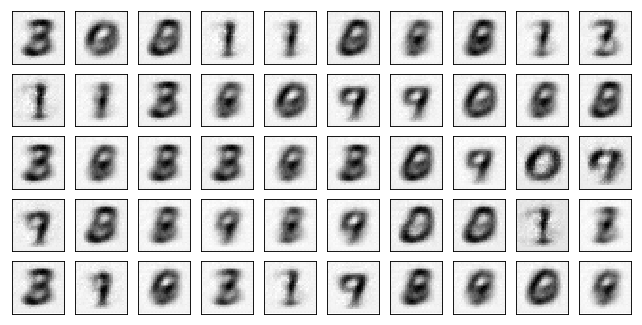

Test losses: VAE2: 0.6434/1.9817
Train Epoch: 2 [0/50000 (0%)]	Losses VAE2: 0.6563
Train Epoch: 2 [10000/50000 (20%)]	Losses VAE2: 0.6304
Train Epoch: 2 [20000/50000 (40%)]	Losses VAE2: 0.5908
Train Epoch: 2 [30000/50000 (60%)]	Losses VAE2: 0.5725
Train Epoch: 2 [40000/50000 (80%)]	Losses VAE2: 0.5462
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE2: 0.5305


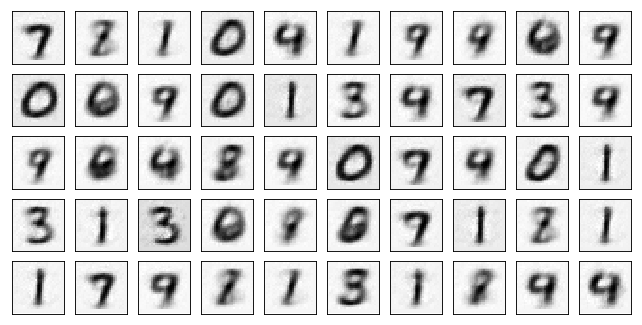

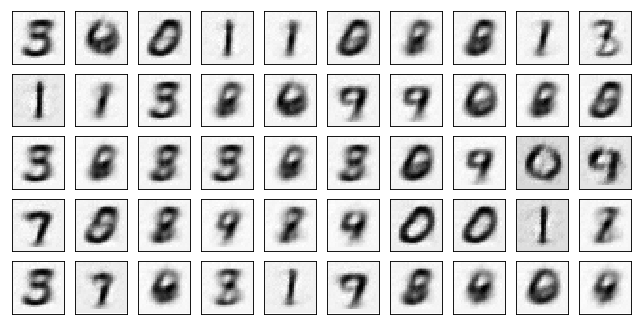

Test losses: VAE2: 0.5167/2.8957
Train Epoch: 3 [0/50000 (0%)]	Losses VAE2: 0.5359
Train Epoch: 3 [10000/50000 (20%)]	Losses VAE2: 0.5051
Train Epoch: 3 [20000/50000 (40%)]	Losses VAE2: 0.4722
Train Epoch: 3 [30000/50000 (60%)]	Losses VAE2: 0.4665
Train Epoch: 3 [40000/50000 (80%)]	Losses VAE2: 0.4555
Train Epoch: 3 [50000/50000 (100%)]	Losses VAE2: 0.4231


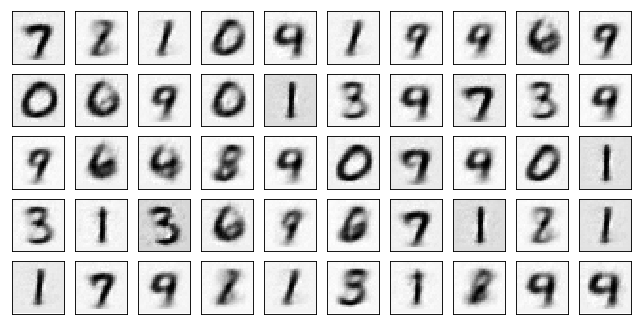

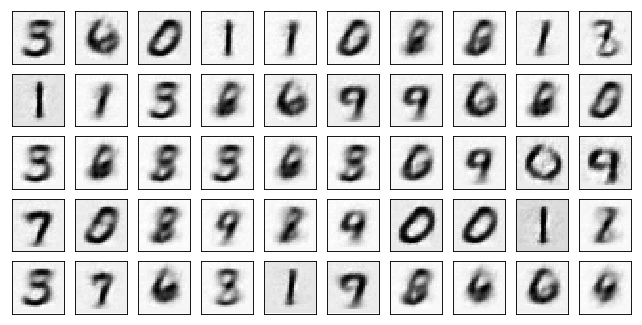

Test losses: VAE2: 0.4279/3.2144
Train Epoch: 4 [0/50000 (0%)]	Losses VAE2: 0.4299
Train Epoch: 4 [10000/50000 (20%)]	Losses VAE2: 0.4175
Train Epoch: 4 [20000/50000 (40%)]	Losses VAE2: 0.4160
Train Epoch: 4 [30000/50000 (60%)]	Losses VAE2: 0.3941
Train Epoch: 4 [40000/50000 (80%)]	Losses VAE2: 0.3755
Train Epoch: 4 [50000/50000 (100%)]	Losses VAE2: 0.3698


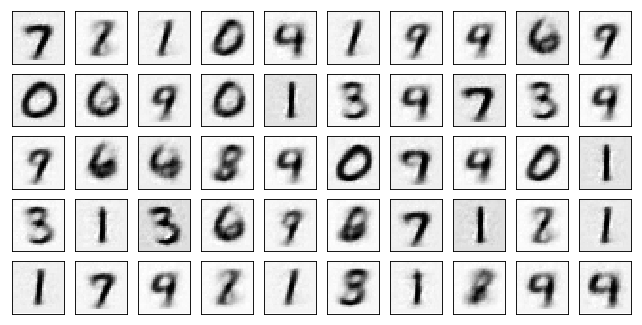

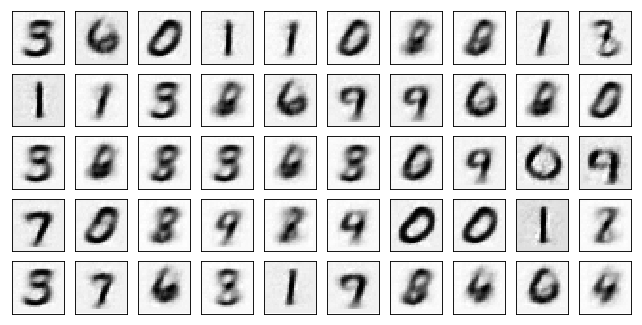

Test losses: VAE2: 0.3629/3.4975
Train Epoch: 5 [0/50000 (0%)]	Losses VAE2: 0.3589
Train Epoch: 5 [10000/50000 (20%)]	Losses VAE2: 0.3432
Train Epoch: 5 [20000/50000 (40%)]	Losses VAE2: 0.3556
Train Epoch: 5 [30000/50000 (60%)]	Losses VAE2: 0.3233
Train Epoch: 5 [40000/50000 (80%)]	Losses VAE2: 0.3373
Train Epoch: 5 [50000/50000 (100%)]	Losses VAE2: 0.3139


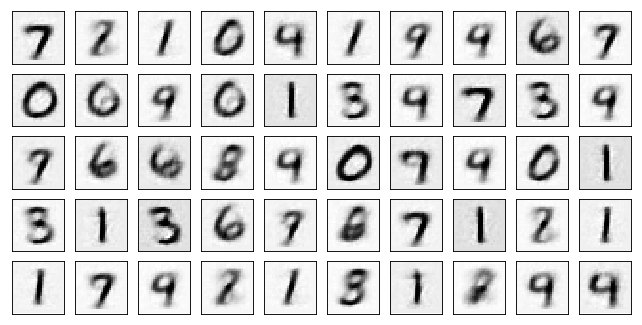

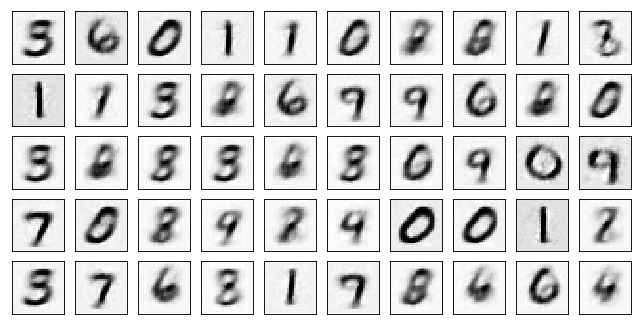

Test losses: VAE2: 0.3084/3.5994
Train Epoch: 6 [0/50000 (0%)]	Losses VAE2: 0.3192
Train Epoch: 6 [10000/50000 (20%)]	Losses VAE2: 0.3173
Train Epoch: 6 [20000/50000 (40%)]	Losses VAE2: 0.3053
Train Epoch: 6 [30000/50000 (60%)]	Losses VAE2: 0.2995
Train Epoch: 6 [40000/50000 (80%)]	Losses VAE2: 0.2951
Train Epoch: 6 [50000/50000 (100%)]	Losses VAE2: 0.2865


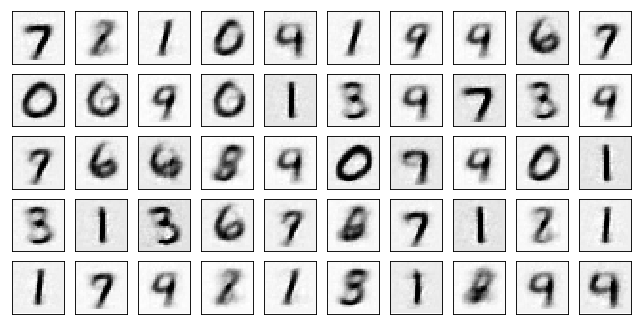

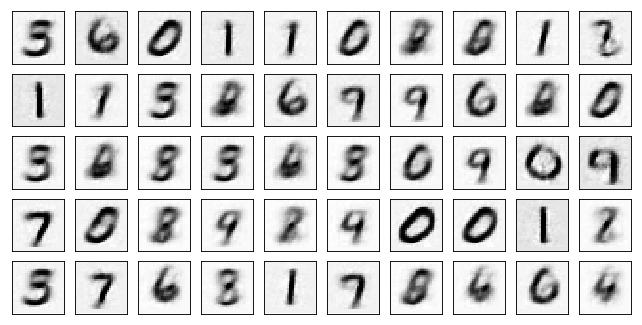

Test losses: VAE2: 0.2766/3.7529
Train Epoch: 7 [0/50000 (0%)]	Losses VAE2: 0.2867
Train Epoch: 7 [10000/50000 (20%)]	Losses VAE2: 0.2736
Train Epoch: 7 [20000/50000 (40%)]	Losses VAE2: 0.2753
Train Epoch: 7 [30000/50000 (60%)]	Losses VAE2: 0.2609
Train Epoch: 7 [40000/50000 (80%)]	Losses VAE2: 0.2596
Train Epoch: 7 [50000/50000 (100%)]	Losses VAE2: 0.2469


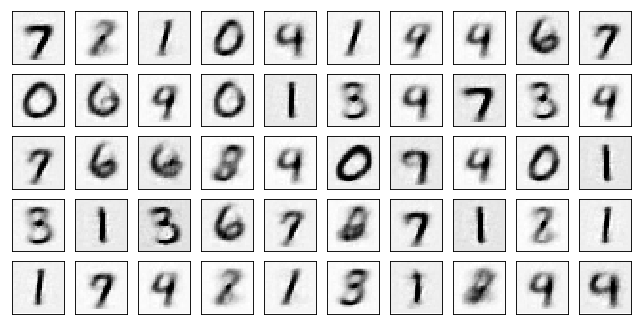

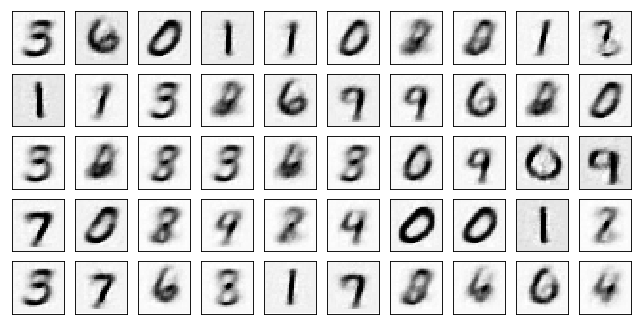

Test losses: VAE2: 0.2456/3.7987
Train Epoch: 8 [0/50000 (0%)]	Losses VAE2: 0.2521
Train Epoch: 8 [10000/50000 (20%)]	Losses VAE2: 0.2593
Train Epoch: 8 [20000/50000 (40%)]	Losses VAE2: 0.2532
Train Epoch: 8 [30000/50000 (60%)]	Losses VAE2: 0.2258
Train Epoch: 8 [40000/50000 (80%)]	Losses VAE2: 0.2199
Train Epoch: 8 [50000/50000 (100%)]	Losses VAE2: 0.2391


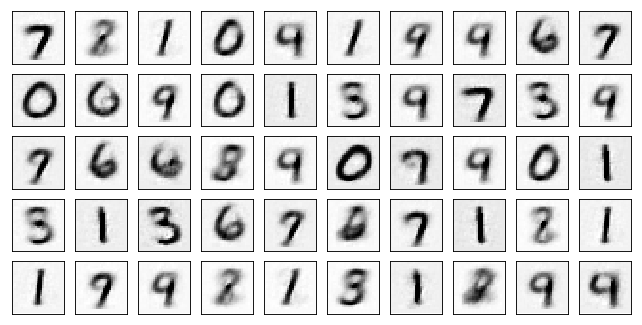

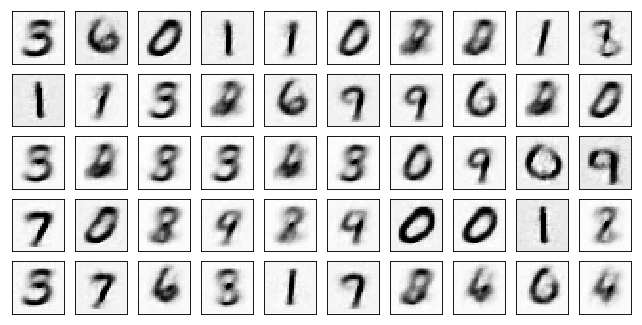

Test losses: VAE2: 0.2328/3.9035
Train Epoch: 9 [0/50000 (0%)]	Losses VAE2: 0.2330
Train Epoch: 9 [10000/50000 (20%)]	Losses VAE2: 0.2212
Train Epoch: 9 [20000/50000 (40%)]	Losses VAE2: 0.2350
Train Epoch: 9 [30000/50000 (60%)]	Losses VAE2: 0.2207
Train Epoch: 9 [40000/50000 (80%)]	Losses VAE2: 0.2216
Train Epoch: 9 [50000/50000 (100%)]	Losses VAE2: 0.2015


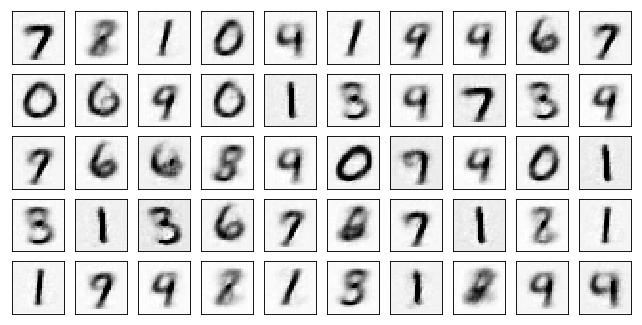

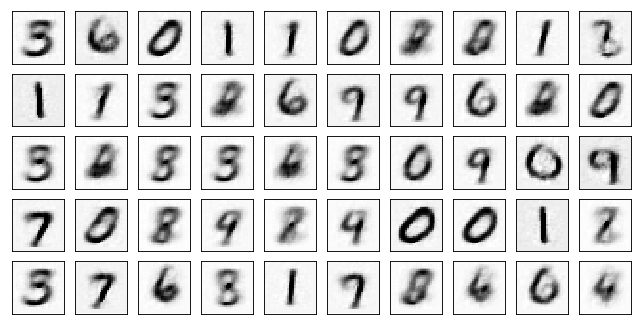

Test losses: VAE2: 0.2165/3.9570
Train Epoch: 10 [0/50000 (0%)]	Losses VAE2: 0.2240
Train Epoch: 10 [10000/50000 (20%)]	Losses VAE2: 0.2307
Train Epoch: 10 [20000/50000 (40%)]	Losses VAE2: 0.2146
Train Epoch: 10 [30000/50000 (60%)]	Losses VAE2: 0.2205
Train Epoch: 10 [40000/50000 (80%)]	Losses VAE2: 0.2050
Train Epoch: 10 [50000/50000 (100%)]	Losses VAE2: 0.2112


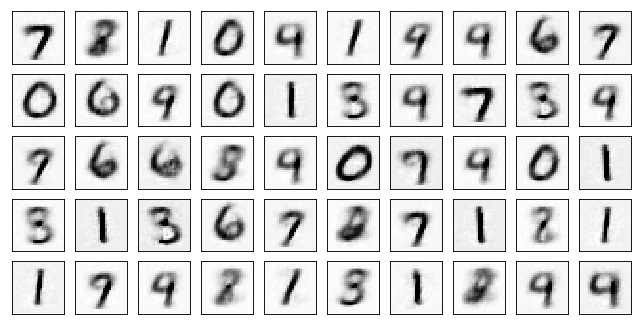

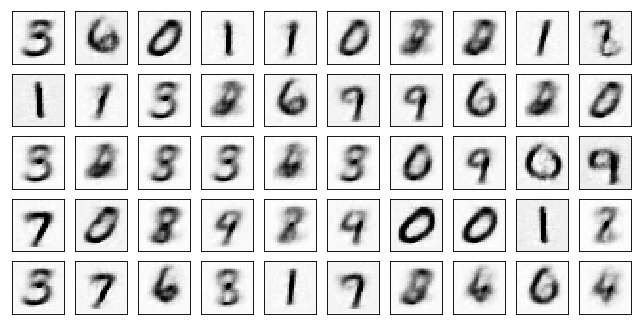

Test losses: VAE2: 0.2043/4.0204
Train Epoch: 11 [0/50000 (0%)]	Losses VAE2: 0.2151
Train Epoch: 11 [10000/50000 (20%)]	Losses VAE2: 0.2245
Train Epoch: 11 [20000/50000 (40%)]	Losses VAE2: 0.1943
Train Epoch: 11 [30000/50000 (60%)]	Losses VAE2: 0.2166
Train Epoch: 11 [40000/50000 (80%)]	Losses VAE2: 0.2152
Train Epoch: 11 [50000/50000 (100%)]	Losses VAE2: 0.1852


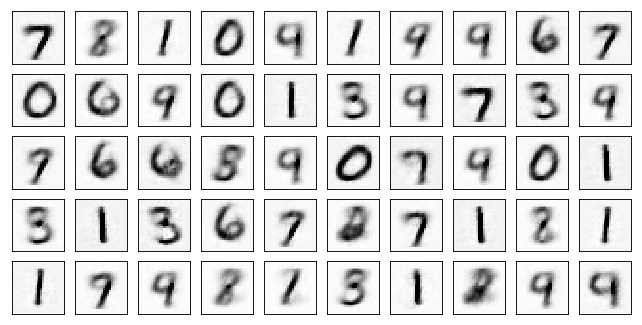

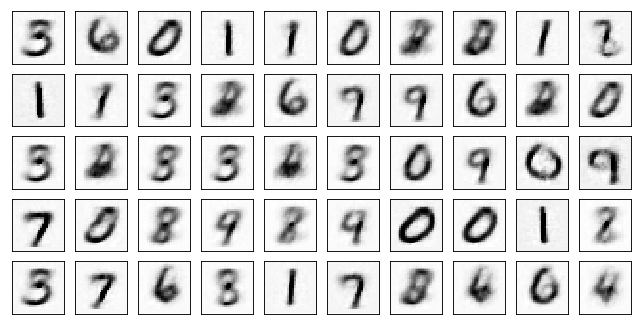

Test losses: VAE2: 0.1965/4.1009
Train Epoch: 12 [0/50000 (0%)]	Losses VAE2: 0.1997
Train Epoch: 12 [10000/50000 (20%)]	Losses VAE2: 0.1839
Train Epoch: 12 [20000/50000 (40%)]	Losses VAE2: 0.1923
Train Epoch: 12 [30000/50000 (60%)]	Losses VAE2: 0.2055
Train Epoch: 12 [40000/50000 (80%)]	Losses VAE2: 0.2001
Train Epoch: 12 [50000/50000 (100%)]	Losses VAE2: 0.1916


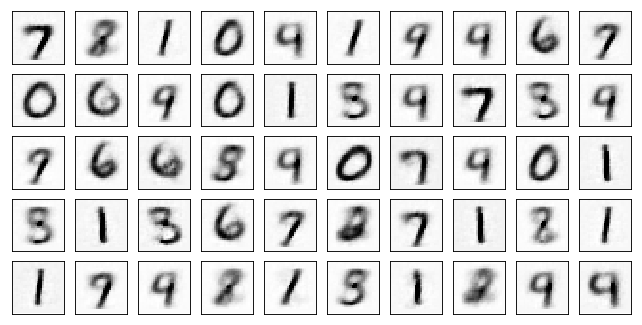

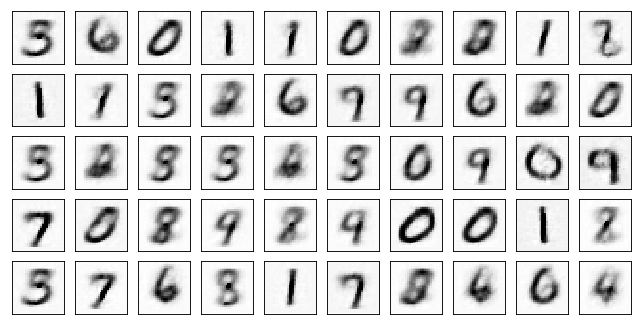

Test losses: VAE2: 0.1905/4.1506
Train Epoch: 13 [0/50000 (0%)]	Losses VAE2: 0.1859
Train Epoch: 13 [10000/50000 (20%)]	Losses VAE2: 0.2014
Train Epoch: 13 [20000/50000 (40%)]	Losses VAE2: 0.1793
Train Epoch: 13 [30000/50000 (60%)]	Losses VAE2: 0.1827
Train Epoch: 13 [40000/50000 (80%)]	Losses VAE2: 0.1879
Train Epoch: 13 [50000/50000 (100%)]	Losses VAE2: 0.1899


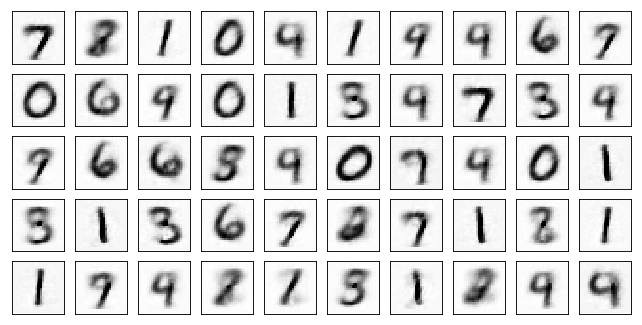

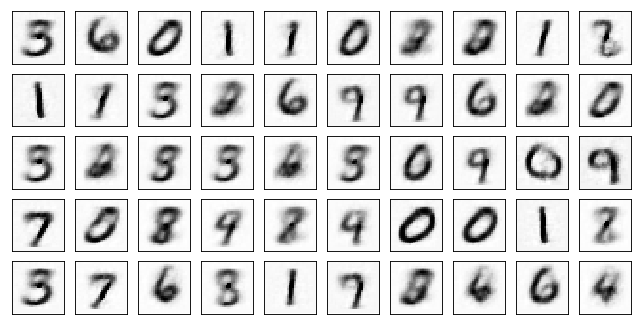

Test losses: VAE2: 0.1860/4.1214
Train Epoch: 14 [0/50000 (0%)]	Losses VAE2: 0.1870
Train Epoch: 14 [10000/50000 (20%)]	Losses VAE2: 0.1726
Train Epoch: 14 [20000/50000 (40%)]	Losses VAE2: 0.1964
Train Epoch: 14 [30000/50000 (60%)]	Losses VAE2: 0.1890
Train Epoch: 14 [40000/50000 (80%)]	Losses VAE2: 0.1754
Train Epoch: 14 [50000/50000 (100%)]	Losses VAE2: 0.1873


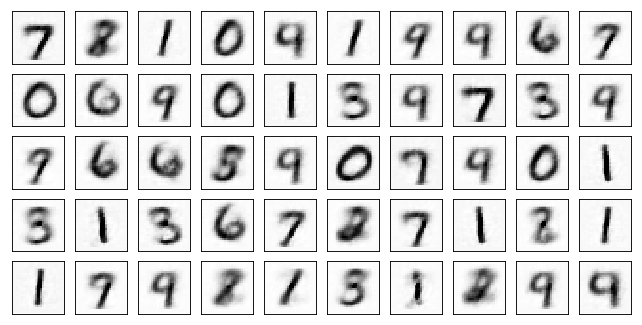

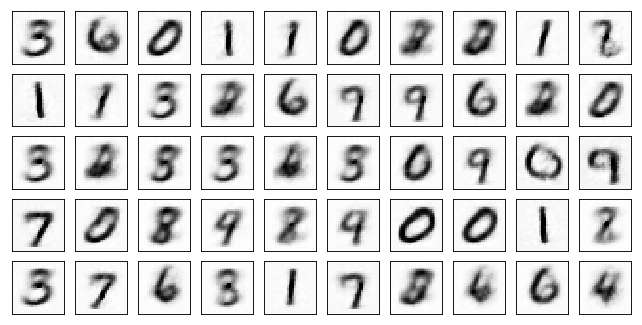

Test losses: VAE2: 0.1823/4.1817
Train Epoch: 15 [0/50000 (0%)]	Losses VAE2: 0.1748
Train Epoch: 15 [10000/50000 (20%)]	Losses VAE2: 0.1912
Train Epoch: 15 [20000/50000 (40%)]	Losses VAE2: 0.1820
Train Epoch: 15 [30000/50000 (60%)]	Losses VAE2: 0.1668
Train Epoch: 15 [40000/50000 (80%)]	Losses VAE2: 0.1840
Train Epoch: 15 [50000/50000 (100%)]	Losses VAE2: 0.1694


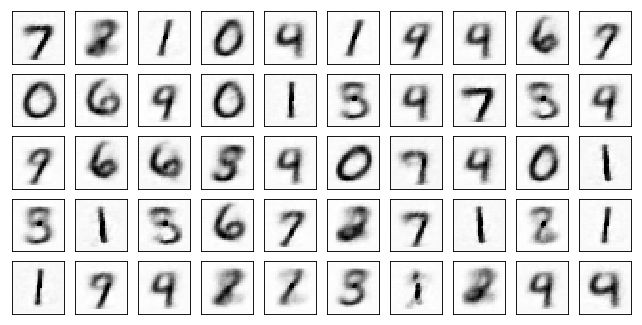

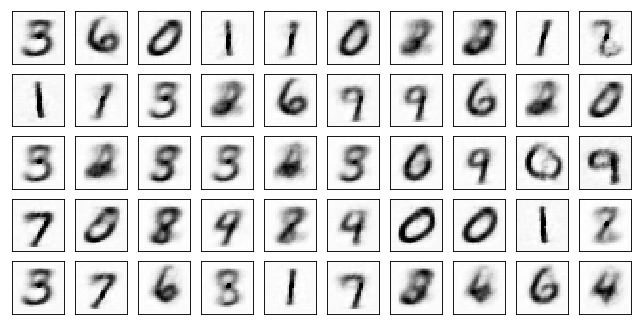

Test losses: VAE2: 0.1792/4.2364
Train Epoch: 16 [0/50000 (0%)]	Losses VAE2: 0.1625
Train Epoch: 16 [10000/50000 (20%)]	Losses VAE2: 0.1752
Train Epoch: 16 [20000/50000 (40%)]	Losses VAE2: 0.1715
Train Epoch: 16 [30000/50000 (60%)]	Losses VAE2: 0.1898
Train Epoch: 16 [40000/50000 (80%)]	Losses VAE2: 0.1721
Train Epoch: 16 [50000/50000 (100%)]	Losses VAE2: 0.1813


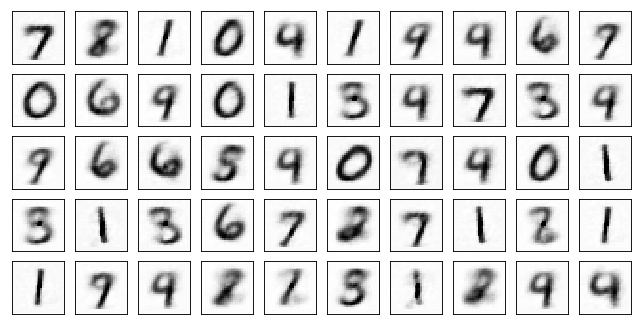

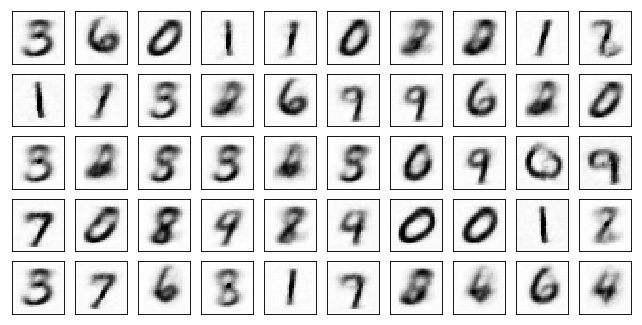

Test losses: VAE2: 0.1771/4.2169
Train Epoch: 17 [0/50000 (0%)]	Losses VAE2: 0.1636
Train Epoch: 17 [10000/50000 (20%)]	Losses VAE2: 0.1867
Train Epoch: 17 [20000/50000 (40%)]	Losses VAE2: 0.1713
Train Epoch: 17 [30000/50000 (60%)]	Losses VAE2: 0.1951
Train Epoch: 17 [40000/50000 (80%)]	Losses VAE2: 0.1884
Train Epoch: 17 [50000/50000 (100%)]	Losses VAE2: 0.1703


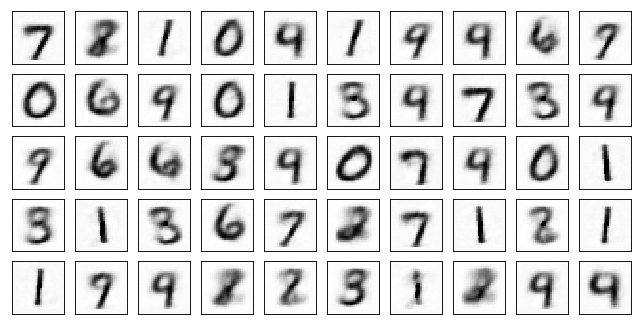

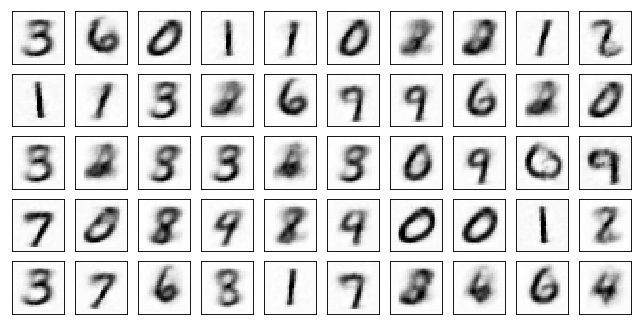

Test losses: VAE2: 0.1755/4.3164
Train Epoch: 18 [0/50000 (0%)]	Losses VAE2: 0.1742
Train Epoch: 18 [10000/50000 (20%)]	Losses VAE2: 0.1764
Train Epoch: 18 [20000/50000 (40%)]	Losses VAE2: 0.2073
Train Epoch: 18 [30000/50000 (60%)]	Losses VAE2: 0.1836
Train Epoch: 18 [40000/50000 (80%)]	Losses VAE2: 0.1793
Train Epoch: 18 [50000/50000 (100%)]	Losses VAE2: 0.1782


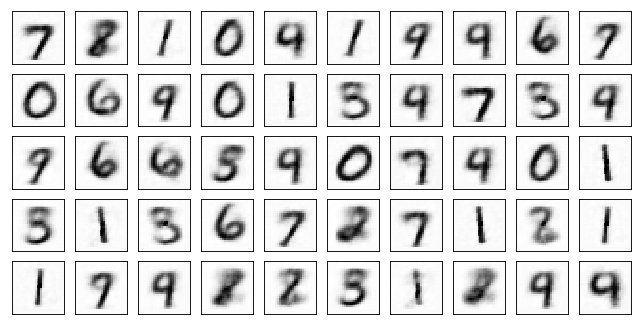

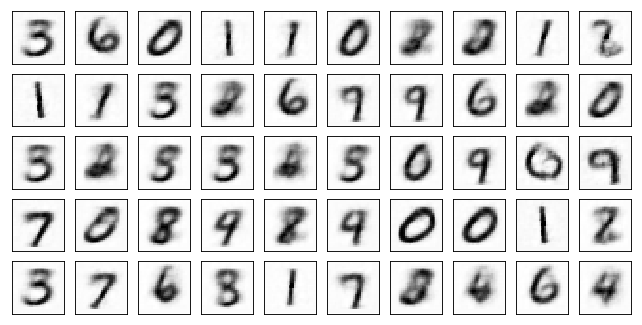

Test losses: VAE2: 0.1740/4.2787
Train Epoch: 19 [0/50000 (0%)]	Losses VAE2: 0.1810
Train Epoch: 19 [10000/50000 (20%)]	Losses VAE2: 0.1769
Train Epoch: 19 [20000/50000 (40%)]	Losses VAE2: 0.1804
Train Epoch: 19 [30000/50000 (60%)]	Losses VAE2: 0.1696
Train Epoch: 19 [40000/50000 (80%)]	Losses VAE2: 0.1707
Train Epoch: 19 [50000/50000 (100%)]	Losses VAE2: 0.1767


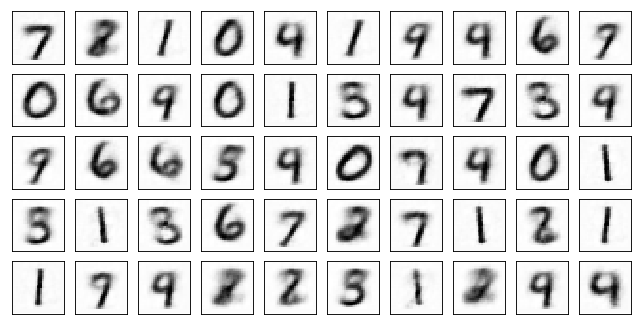

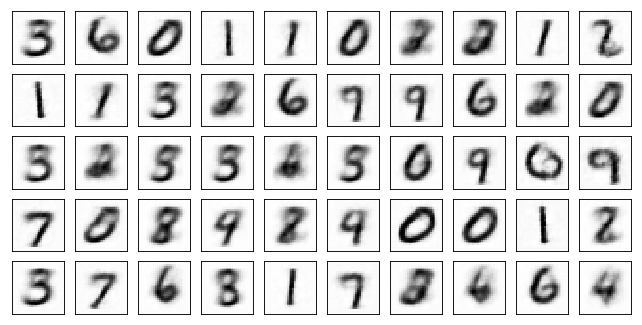

Test losses: VAE2: 0.1725/4.3512
Train Epoch: 20 [0/50000 (0%)]	Losses VAE2: 0.1794
Train Epoch: 20 [10000/50000 (20%)]	Losses VAE2: 0.1599
Train Epoch: 20 [20000/50000 (40%)]	Losses VAE2: 0.1691
Train Epoch: 20 [30000/50000 (60%)]	Losses VAE2: 0.1819
Train Epoch: 20 [40000/50000 (80%)]	Losses VAE2: 0.1801
Train Epoch: 20 [50000/50000 (100%)]	Losses VAE2: 0.1692


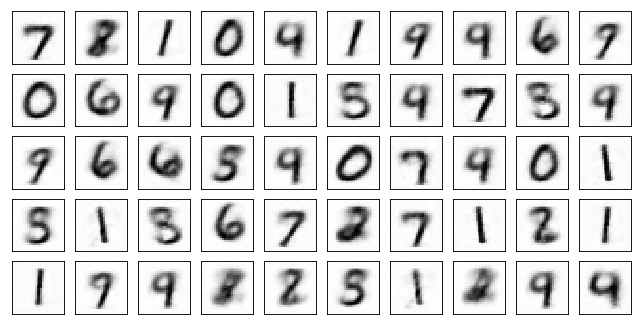

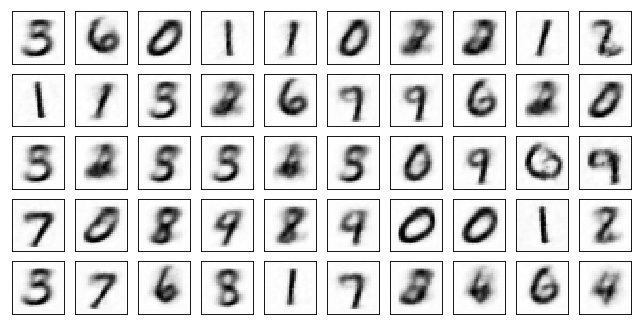

Test losses: VAE2: 0.1720/4.3654
Train Epoch: 21 [0/50000 (0%)]	Losses VAE2: 0.1704
Train Epoch: 21 [10000/50000 (20%)]	Losses VAE2: 0.1690
Train Epoch: 21 [20000/50000 (40%)]	Losses VAE2: 0.1651
Train Epoch: 21 [30000/50000 (60%)]	Losses VAE2: 0.1733
Train Epoch: 21 [40000/50000 (80%)]	Losses VAE2: 0.1833
Train Epoch: 21 [50000/50000 (100%)]	Losses VAE2: 0.1717


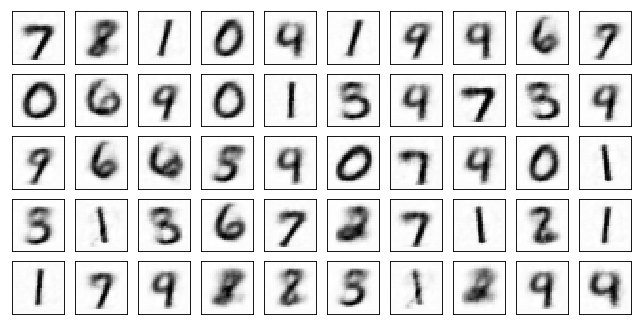

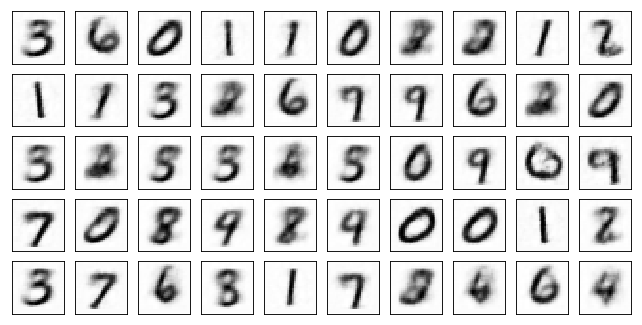

Test losses: VAE2: 0.1711/4.4084
Train Epoch: 22 [0/50000 (0%)]	Losses VAE2: 0.1653
Train Epoch: 22 [10000/50000 (20%)]	Losses VAE2: 0.1524
Train Epoch: 22 [20000/50000 (40%)]	Losses VAE2: 0.1662
Train Epoch: 22 [30000/50000 (60%)]	Losses VAE2: 0.1729
Train Epoch: 22 [40000/50000 (80%)]	Losses VAE2: 0.1751
Train Epoch: 22 [50000/50000 (100%)]	Losses VAE2: 0.1804


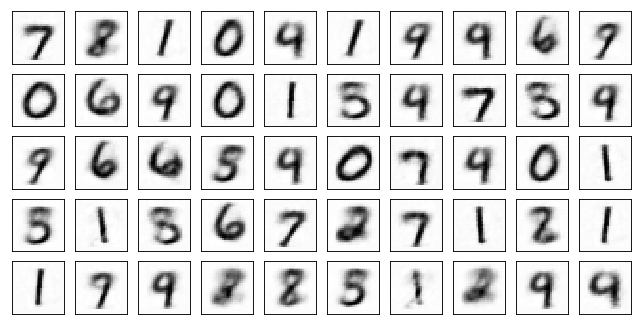

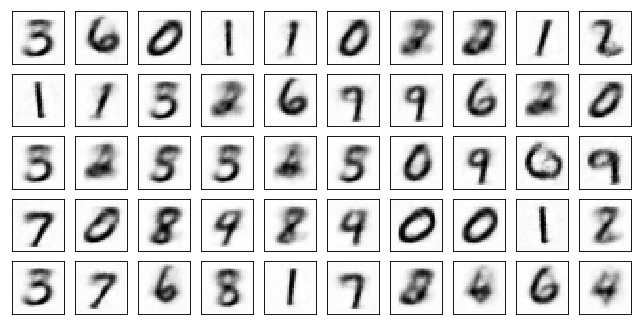

Test losses: VAE2: 0.1700/4.4389
Train Epoch: 23 [0/50000 (0%)]	Losses VAE2: 0.1809
Train Epoch: 23 [10000/50000 (20%)]	Losses VAE2: 0.1632
Train Epoch: 23 [20000/50000 (40%)]	Losses VAE2: 0.1846
Train Epoch: 23 [30000/50000 (60%)]	Losses VAE2: 0.1777
Train Epoch: 23 [40000/50000 (80%)]	Losses VAE2: 0.1952
Train Epoch: 23 [50000/50000 (100%)]	Losses VAE2: 0.1651


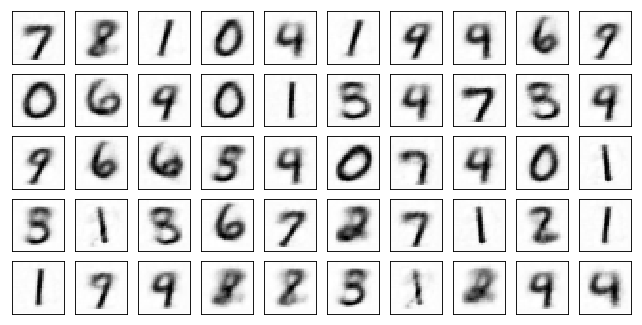

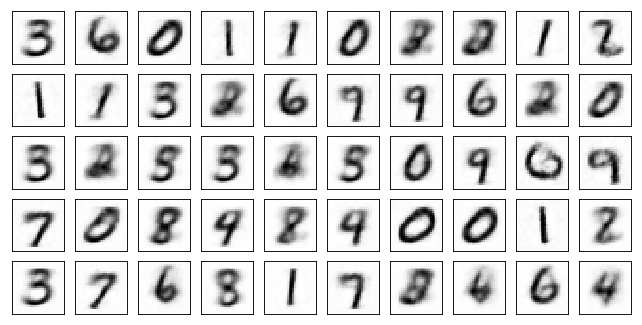

Test losses: VAE2: 0.1699/4.4211
Train Epoch: 24 [0/50000 (0%)]	Losses VAE2: 0.1672
Train Epoch: 24 [10000/50000 (20%)]	Losses VAE2: 0.1604
Train Epoch: 24 [20000/50000 (40%)]	Losses VAE2: 0.1600
Train Epoch: 24 [30000/50000 (60%)]	Losses VAE2: 0.1821
Train Epoch: 24 [40000/50000 (80%)]	Losses VAE2: 0.1543
Train Epoch: 24 [50000/50000 (100%)]	Losses VAE2: 0.1660


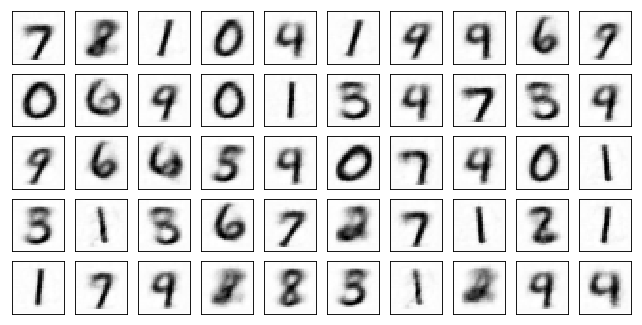

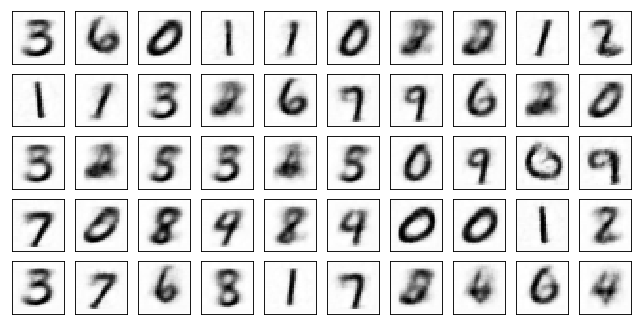

Test losses: VAE2: 0.1690/4.4802
Train Epoch: 25 [0/50000 (0%)]	Losses VAE2: 0.1735
Train Epoch: 25 [10000/50000 (20%)]	Losses VAE2: 0.1784
Train Epoch: 25 [20000/50000 (40%)]	Losses VAE2: 0.1742
Train Epoch: 25 [30000/50000 (60%)]	Losses VAE2: 0.1726
Train Epoch: 25 [40000/50000 (80%)]	Losses VAE2: 0.1514
Train Epoch: 25 [50000/50000 (100%)]	Losses VAE2: 0.1697


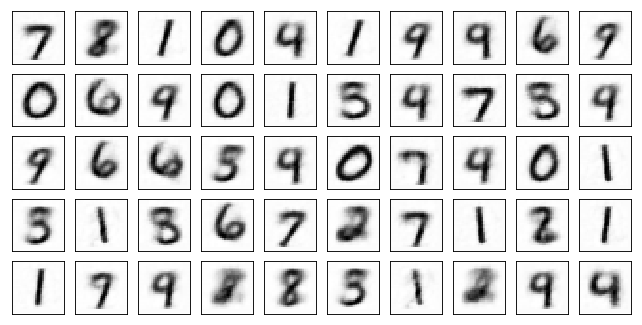

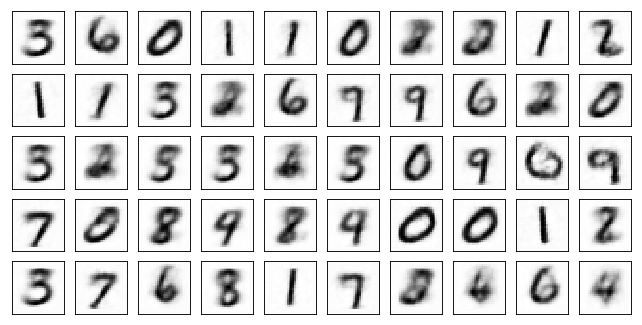

Test losses: VAE2: 0.1687/4.4777
Train Epoch: 26 [0/50000 (0%)]	Losses VAE2: 0.1622
Train Epoch: 26 [10000/50000 (20%)]	Losses VAE2: 0.1695
Train Epoch: 26 [20000/50000 (40%)]	Losses VAE2: 0.1767
Train Epoch: 26 [30000/50000 (60%)]	Losses VAE2: 0.1794
Train Epoch: 26 [40000/50000 (80%)]	Losses VAE2: 0.1808
Train Epoch: 26 [50000/50000 (100%)]	Losses VAE2: 0.1741


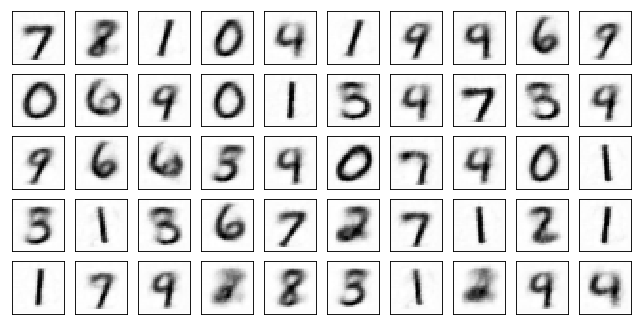

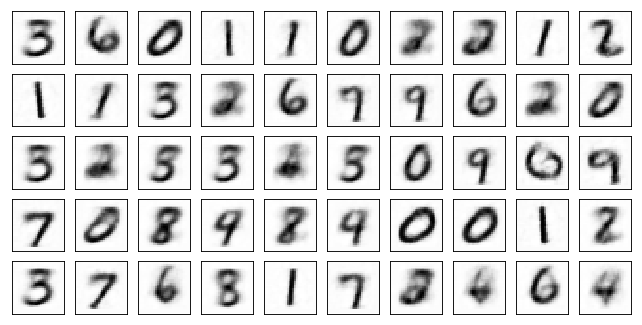

Test losses: VAE2: 0.1684/4.5213
Train Epoch: 27 [0/50000 (0%)]	Losses VAE2: 0.1671
Train Epoch: 27 [10000/50000 (20%)]	Losses VAE2: 0.1593
Train Epoch: 27 [20000/50000 (40%)]	Losses VAE2: 0.1835
Train Epoch: 27 [30000/50000 (60%)]	Losses VAE2: 0.1597
Train Epoch: 27 [40000/50000 (80%)]	Losses VAE2: 0.1806
Train Epoch: 27 [50000/50000 (100%)]	Losses VAE2: 0.1672


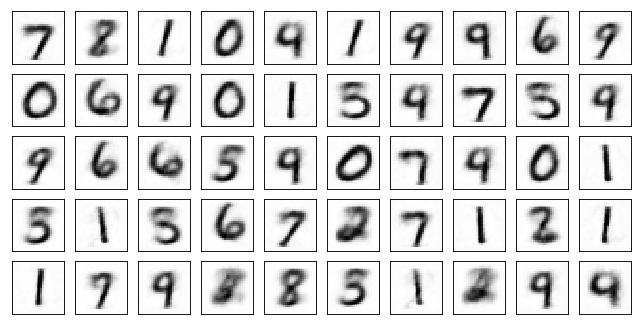

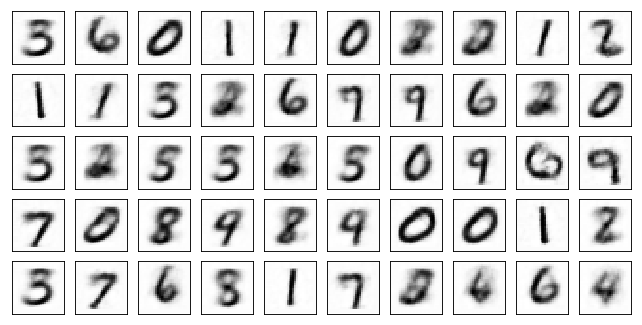

Test losses: VAE2: 0.1678/4.5035
Train Epoch: 28 [0/50000 (0%)]	Losses VAE2: 0.1857
Train Epoch: 28 [10000/50000 (20%)]	Losses VAE2: 0.1847
Train Epoch: 28 [20000/50000 (40%)]	Losses VAE2: 0.1738
Train Epoch: 28 [30000/50000 (60%)]	Losses VAE2: 0.1872
Train Epoch: 28 [40000/50000 (80%)]	Losses VAE2: 0.1684
Train Epoch: 28 [50000/50000 (100%)]	Losses VAE2: 0.1935


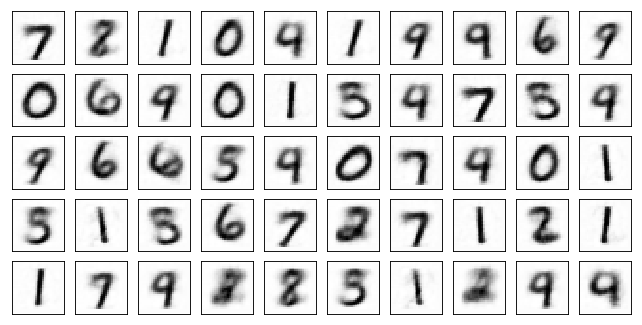

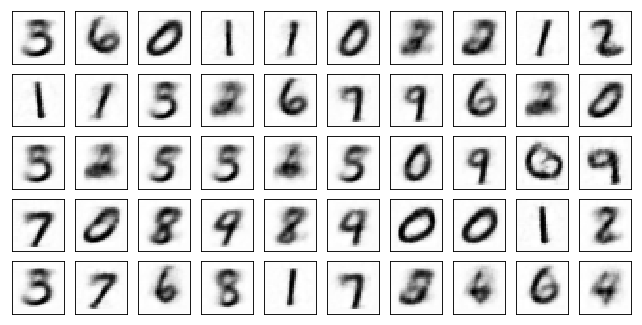

Test losses: VAE2: 0.1687/4.5498
Train Epoch: 29 [0/50000 (0%)]	Losses VAE2: 0.1659
Train Epoch: 29 [10000/50000 (20%)]	Losses VAE2: 0.1546
Train Epoch: 29 [20000/50000 (40%)]	Losses VAE2: 0.1851
Train Epoch: 29 [30000/50000 (60%)]	Losses VAE2: 0.1844
Train Epoch: 29 [40000/50000 (80%)]	Losses VAE2: 0.1692
Train Epoch: 29 [50000/50000 (100%)]	Losses VAE2: 0.1693


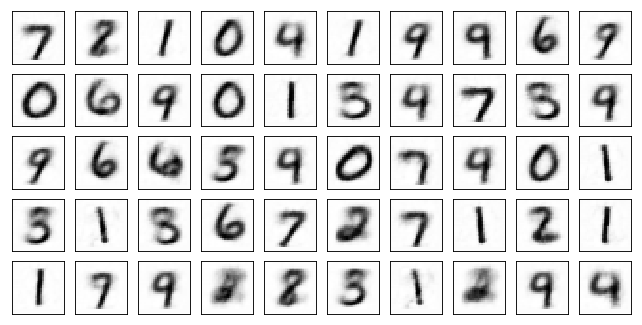

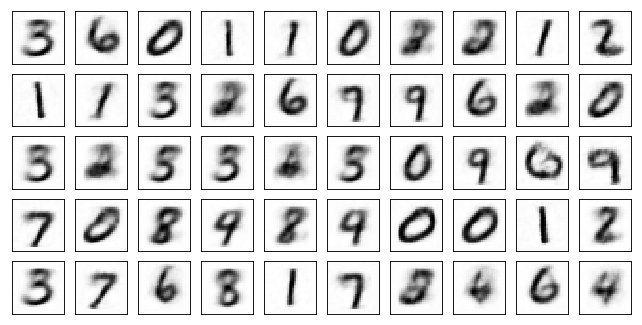

Test losses: VAE2: 0.1665/4.5591
Train Epoch: 30 [0/50000 (0%)]	Losses VAE2: 0.1835
Train Epoch: 30 [10000/50000 (20%)]	Losses VAE2: 0.1630
Train Epoch: 30 [20000/50000 (40%)]	Losses VAE2: 0.1540
Train Epoch: 30 [30000/50000 (60%)]	Losses VAE2: 0.1692
Train Epoch: 30 [40000/50000 (80%)]	Losses VAE2: 0.1723
Train Epoch: 30 [50000/50000 (100%)]	Losses VAE2: 0.1703


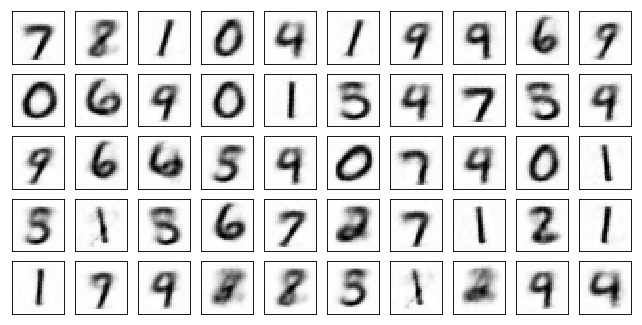

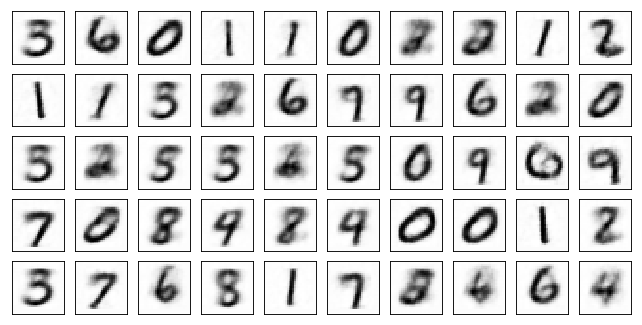

Test losses: VAE2: 0.1669/4.5564
Train Epoch: 31 [0/50000 (0%)]	Losses VAE2: 0.1621
Train Epoch: 31 [10000/50000 (20%)]	Losses VAE2: 0.1642
Train Epoch: 31 [20000/50000 (40%)]	Losses VAE2: 0.1735
Train Epoch: 31 [30000/50000 (60%)]	Losses VAE2: 0.1652
Train Epoch: 31 [40000/50000 (80%)]	Losses VAE2: 0.1680
Train Epoch: 31 [50000/50000 (100%)]	Losses VAE2: 0.1658


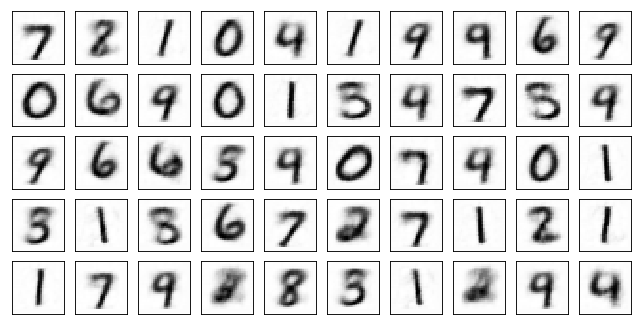

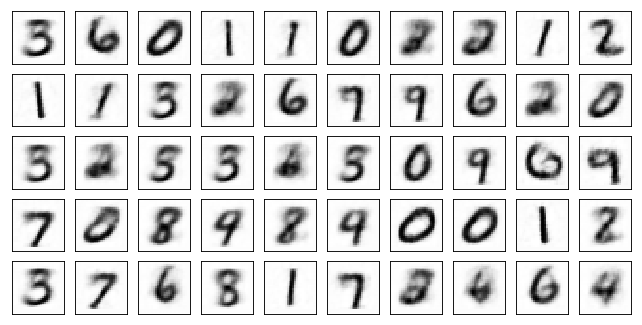

Test losses: VAE2: 0.1660/4.5907
Train Epoch: 32 [0/50000 (0%)]	Losses VAE2: 0.1708
Train Epoch: 32 [10000/50000 (20%)]	Losses VAE2: 0.1733
Train Epoch: 32 [20000/50000 (40%)]	Losses VAE2: 0.1827
Train Epoch: 32 [30000/50000 (60%)]	Losses VAE2: 0.1498
Train Epoch: 32 [40000/50000 (80%)]	Losses VAE2: 0.1870
Train Epoch: 32 [50000/50000 (100%)]	Losses VAE2: 0.1738


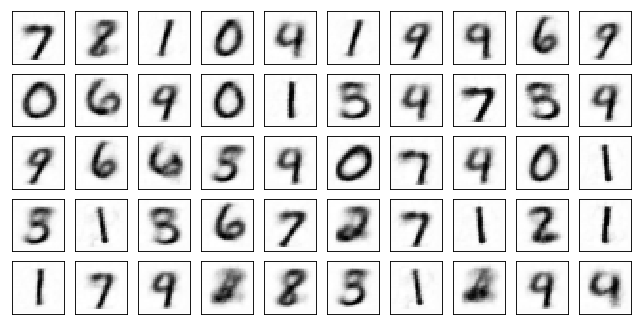

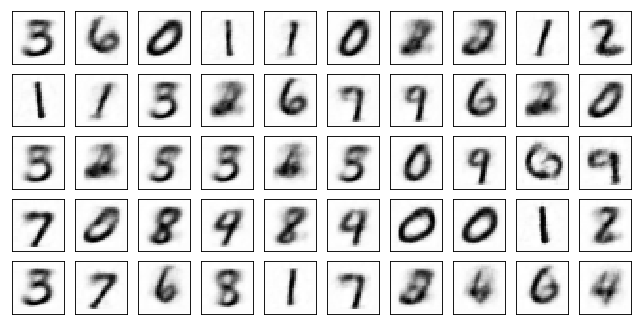

Test losses: VAE2: 0.1662/4.5937
Train Epoch: 33 [0/50000 (0%)]	Losses VAE2: 0.1833
Train Epoch: 33 [10000/50000 (20%)]	Losses VAE2: 0.1610
Train Epoch: 33 [20000/50000 (40%)]	Losses VAE2: 0.1883
Train Epoch: 33 [30000/50000 (60%)]	Losses VAE2: 0.1633
Train Epoch: 33 [40000/50000 (80%)]	Losses VAE2: 0.1612
Train Epoch: 33 [50000/50000 (100%)]	Losses VAE2: 0.1620


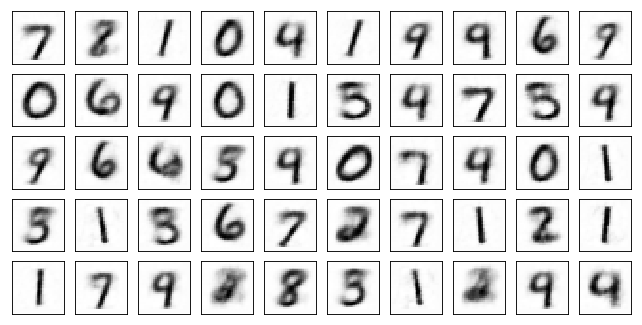

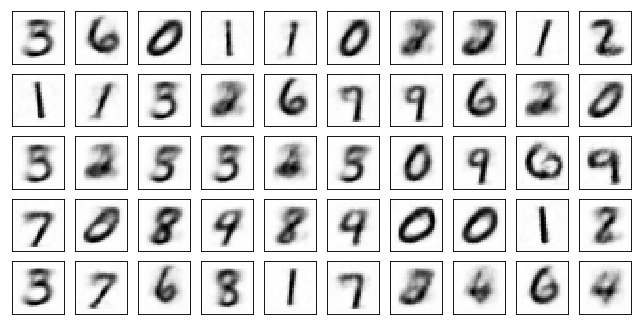

Test losses: VAE2: 0.1659/4.6193
Train Epoch: 34 [0/50000 (0%)]	Losses VAE2: 0.2000
Train Epoch: 34 [10000/50000 (20%)]	Losses VAE2: 0.1596
Train Epoch: 34 [20000/50000 (40%)]	Losses VAE2: 0.1432
Train Epoch: 34 [30000/50000 (60%)]	Losses VAE2: 0.1757
Train Epoch: 34 [40000/50000 (80%)]	Losses VAE2: 0.1762
Train Epoch: 34 [50000/50000 (100%)]	Losses VAE2: 0.1570


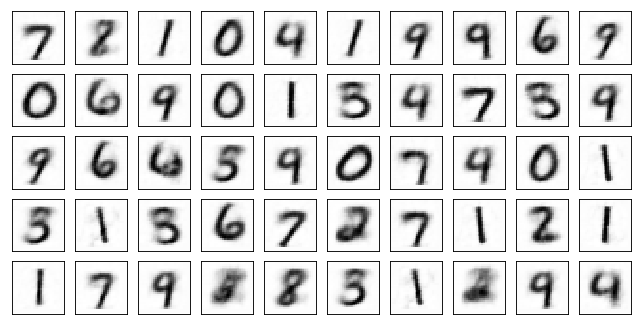

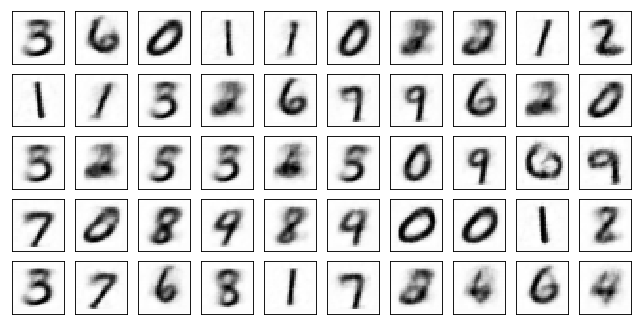

Test losses: VAE2: 0.1649/4.6202
Train Epoch: 35 [0/50000 (0%)]	Losses VAE2: 0.1673
Train Epoch: 35 [10000/50000 (20%)]	Losses VAE2: 0.1540
Train Epoch: 35 [20000/50000 (40%)]	Losses VAE2: 0.1904
Train Epoch: 35 [30000/50000 (60%)]	Losses VAE2: 0.1760
Train Epoch: 35 [40000/50000 (80%)]	Losses VAE2: 0.1545
Train Epoch: 35 [50000/50000 (100%)]	Losses VAE2: 0.1873


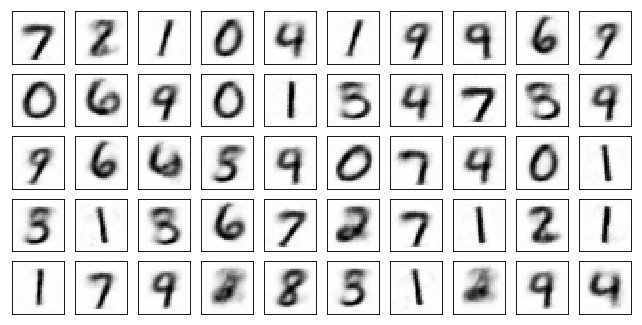

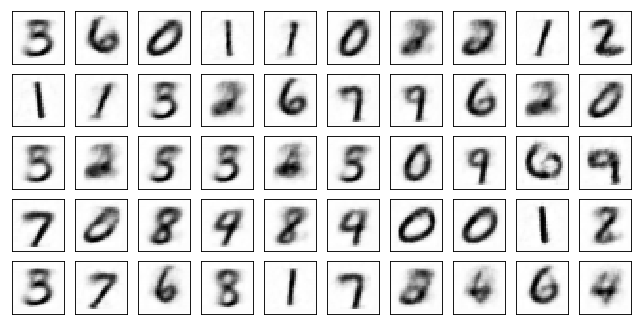

Test losses: VAE2: 0.1654/4.6637
Train Epoch: 36 [0/50000 (0%)]	Losses VAE2: 0.1648
Train Epoch: 36 [10000/50000 (20%)]	Losses VAE2: 0.1660
Train Epoch: 36 [20000/50000 (40%)]	Losses VAE2: 0.1587
Train Epoch: 36 [30000/50000 (60%)]	Losses VAE2: 0.1480
Train Epoch: 36 [40000/50000 (80%)]	Losses VAE2: 0.1656
Train Epoch: 36 [50000/50000 (100%)]	Losses VAE2: 0.1753


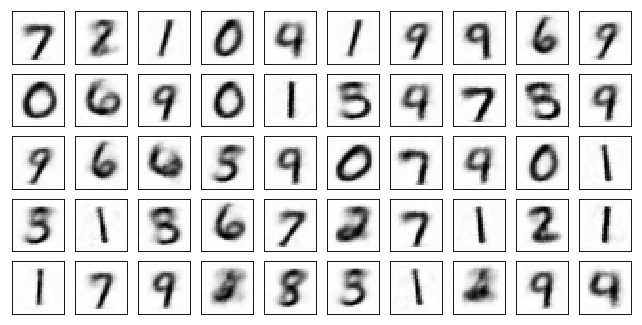

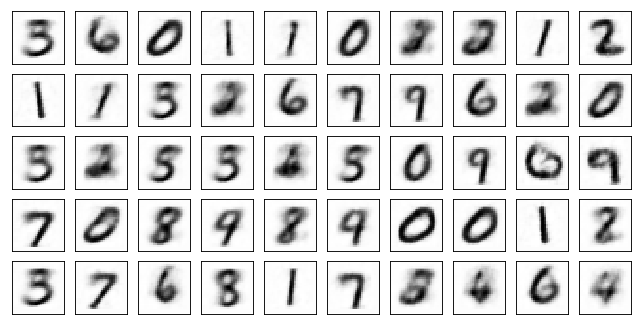

Test losses: VAE2: 0.1657/4.7057
Train Epoch: 37 [0/50000 (0%)]	Losses VAE2: 0.1575
Train Epoch: 37 [10000/50000 (20%)]	Losses VAE2: 0.1708
Train Epoch: 37 [20000/50000 (40%)]	Losses VAE2: 0.1934
Train Epoch: 37 [30000/50000 (60%)]	Losses VAE2: 0.1729
Train Epoch: 37 [40000/50000 (80%)]	Losses VAE2: 0.1620
Train Epoch: 37 [50000/50000 (100%)]	Losses VAE2: 0.1444


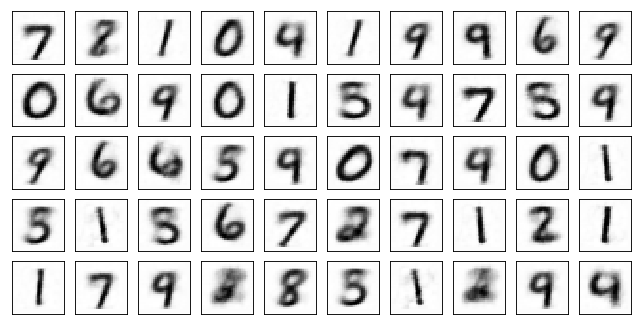

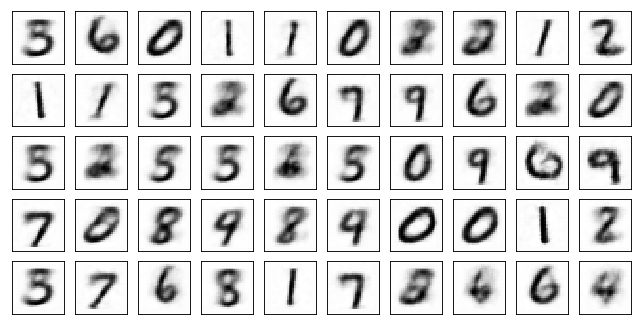

Test losses: VAE2: 0.1652/4.6551
Train Epoch: 38 [0/50000 (0%)]	Losses VAE2: 0.1653
Train Epoch: 38 [10000/50000 (20%)]	Losses VAE2: 0.1633
Train Epoch: 38 [20000/50000 (40%)]	Losses VAE2: 0.1710
Train Epoch: 38 [30000/50000 (60%)]	Losses VAE2: 0.1734
Train Epoch: 38 [40000/50000 (80%)]	Losses VAE2: 0.1453
Train Epoch: 38 [50000/50000 (100%)]	Losses VAE2: 0.1716


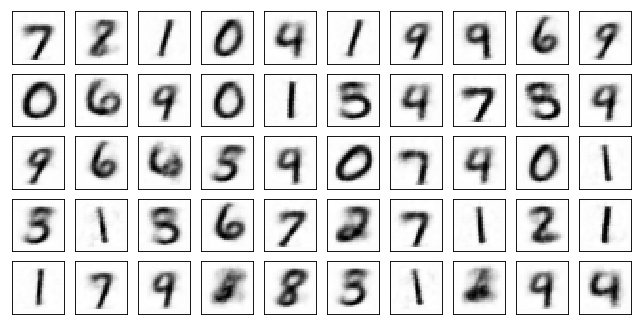

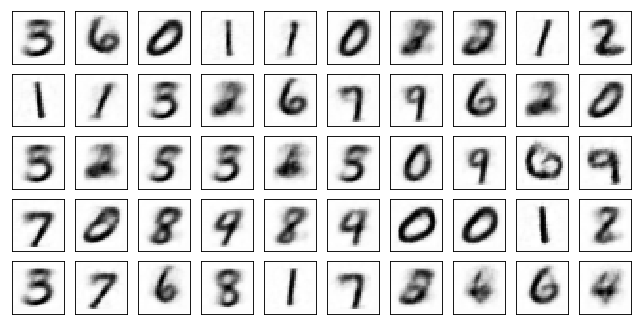

Test losses: VAE2: 0.1643/4.6473
Train Epoch: 39 [0/50000 (0%)]	Losses VAE2: 0.1576
Train Epoch: 39 [10000/50000 (20%)]	Losses VAE2: 0.1720
Train Epoch: 39 [20000/50000 (40%)]	Losses VAE2: 0.1670
Train Epoch: 39 [30000/50000 (60%)]	Losses VAE2: 0.1789
Train Epoch: 39 [40000/50000 (80%)]	Losses VAE2: 0.1665
Train Epoch: 39 [50000/50000 (100%)]	Losses VAE2: 0.1631


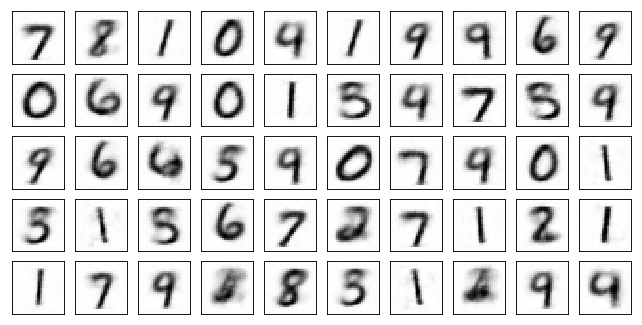

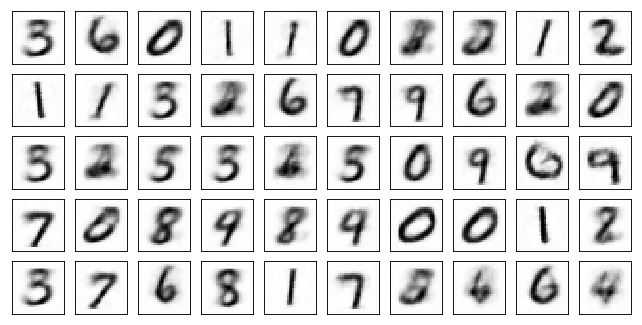

Test losses: VAE2: 0.1644/4.6641
Train Epoch: 40 [0/50000 (0%)]	Losses VAE2: 0.1721
Train Epoch: 40 [10000/50000 (20%)]	Losses VAE2: 0.1685
Train Epoch: 40 [20000/50000 (40%)]	Losses VAE2: 0.1772
Train Epoch: 40 [30000/50000 (60%)]	Losses VAE2: 0.1476
Train Epoch: 40 [40000/50000 (80%)]	Losses VAE2: 0.1725
Train Epoch: 40 [50000/50000 (100%)]	Losses VAE2: 0.1748


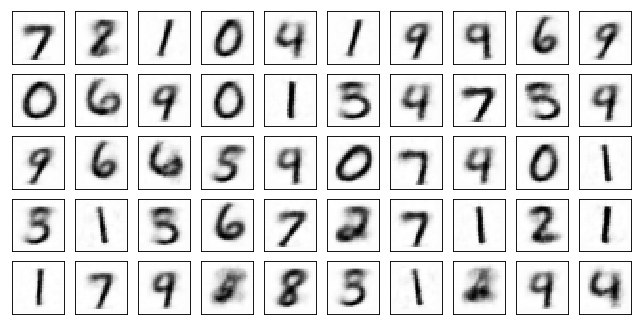

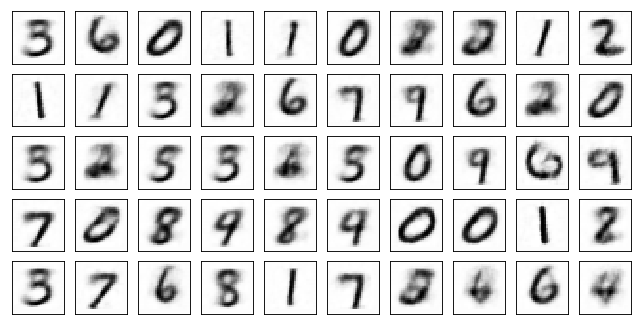

Test losses: VAE2: 0.1639/4.7173


In [13]:
with torch.cuda.device(0):
    for epoch in range(1, 41):
        for model in models.values():
            model.train()
        train(epoch, models, train_log)
        for model in models.values():
            model.eval()
        test(models, valid_loader, epoch, test_log)

# Задание 1. Визуализировать двумерный латентный слой VAE. Показать, какие цифры генерируются из каких точек в латентном слое.

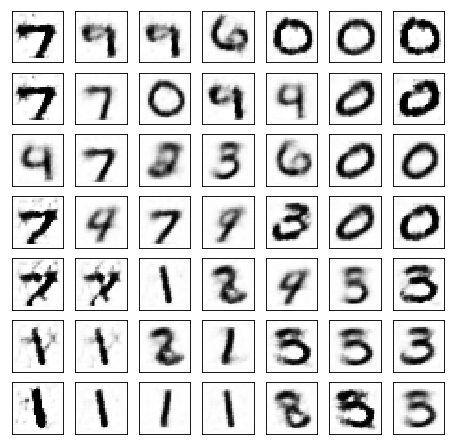

In [78]:
sig = torch.eye(2)
to_plot = []
for i in range(-3, 4, 1):
    for j in range(-3, 4, 1):
        mu = torch.Tensor([i, j])
        # specifying distribution parameters
        dist = torch.distributions.MultivariateNormal(mu, sig)
        # sampling from a specific region
        sampled_point = models['VAE2'].decode(dist.sample((1,))).data.numpy()
        to_plot.append(sampled_point)

# plotting figures sampled from different regions        
to_plot = np.array(to_plot).reshape(-1, 1, 28, 28)
plot_mnist(to_plot, (7, 7))

# Задание 2. Обучить условный VAE. Для этого добавить one-hot вектор класса ко входу декодировщика.

In [8]:
# conditional VAE

class Net(nn.Module):
    def __init__(self, latent_size=32, gamma=1e-3, batchnorm=False, dropout=False, optim_type='Adam', **optim_params):
        super(Net, self).__init__()
    
        self.latent_size = latent_size
        self.gamma = gamma
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, pool_layer=None)
            
        self.fce = FullyConnected([32*2*2, latent_size*2])
        self.fcd = FullyConnected([latent_size*2, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        h = self.fce(flatten)
        self.mu, self.logvar = h.split(self.latent_size, dim=1)
        return self.mu, self.logvar
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def forward(self, x, y):
        mu, logvar = self.encode(x)
        if self.training:
            std = logvar.mul(0.5).exp()
            h = self._sample(mu.shape[0]) * std + mu
        else:
            h = mu
        x = self.decode(torch.cat((h, y), 1))
        return x
    
    def _sample(self, n):
        return torch.randn([n, self.latent_size])
    
    def loss(self, output, target, size_average=True):
        KLD = self.mu**2 + self.logvar.exp() - 1 - self.logvar
        KLD = 0.5*KLD.sum(1)
        if size_average:
            self.KLD = KLD.mean()
        else:
            self.KLD = KLD.sum()
        self._loss = F.mse_loss(output, target, size_average=size_average)
        
        return self._loss + self.gamma*self.KLD

In [9]:
models = {'VAE10_cond': Net(10, 0.005, batchnorm=True, lr=1e-4)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [10]:
def train(epoch, models, log=None):
    with torch.cuda.device(0):
        train_size = len(train_loader.sampler)
        for batch_idx, (data, labels) in enumerate(train_loader):
            for model in models.values():
                model.optim.zero_grad()
                labels = torch.eye(10)[labels] # one-hot encoding labels
                output = model(data, labels)
                loss = model.loss(output, data)
                loss.backward()
                model.optim.step()

            if batch_idx % 200 == 0:
                line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                    epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
                losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
                print(line + losses)

        else:
            batch_idx += 1
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            if log is not None:
                for k in models:
                    log[k].append((models[k]._loss,))
            print(line + losses)

In [11]:
def test(models, loader, epoch, log=None):
    with torch.cuda.device(0):
        test_size = len(loader)
        test_reconstruction_loss = {k: 0. for k in models}
        test_KL_loss = {k: 0. for k in models}
        with torch.no_grad():
            for data, labels in loader:
                labels = torch.eye(10)[labels]
                output = {k: m(data, labels) for k, m in models.items()}
                for k, m in models.items():
                    m.loss(output[k], data)
                    test_reconstruction_loss[k] += m._loss.item()
                    test_KL_loss[k] += m.KLD.item()

        for k in models:
            test_reconstruction_loss[k] /= test_size
            test_KL_loss[k] /= test_size
        report = 'Test losses: ' + ' '.join(['{}: {:.4f}/{:.4f}'.format(k, 
                                                                        test_reconstruction_loss[k], 
                                                                        test_KL_loss[k]) for k in models])
        for k in models:
            if log is not None:
                log[k].append((test_reconstruction_loss[k], test_KL_loss[k]))
        print(report)

In [12]:
with torch.cuda.device(0):
    for epoch in range(1, 31):
        for model in models.values():
            model.train()
        train(epoch, models, train_log)
        for model in models.values():
            model.eval()
        test(models, valid_loader, epoch, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses VAE10_cond: 0.9644
Train Epoch: 1 [10000/50000 (20%)]	Losses VAE10_cond: 0.8090
Train Epoch: 1 [20000/50000 (40%)]	Losses VAE10_cond: 0.7547
Train Epoch: 1 [30000/50000 (60%)]	Losses VAE10_cond: 0.7159
Train Epoch: 1 [40000/50000 (80%)]	Losses VAE10_cond: 0.6627
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE10_cond: 0.6304
Test losses: VAE10_cond: 0.6007/2.1062
Train Epoch: 2 [0/50000 (0%)]	Losses VAE10_cond: 0.6378
Train Epoch: 2 [10000/50000 (20%)]	Losses VAE10_cond: 0.5967
Train Epoch: 2 [20000/50000 (40%)]	Losses VAE10_cond: 0.5724
Train Epoch: 2 [30000/50000 (60%)]	Losses VAE10_cond: 0.5306
Train Epoch: 2 [40000/50000 (80%)]	Losses VAE10_cond: 0.5152
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE10_cond: 0.4776
Test losses: VAE10_cond: 0.4651/3.6135
Train Epoch: 3 [0/50000 (0%)]	Losses VAE10_cond: 0.4999
Train Epoch: 3 [10000/50000 (20%)]	Losses VAE10_cond: 0.4704
Train Epoch: 3 [20000/50000 (40%)]	Losses VAE10_cond: 0.4260
Train Epoch: 3 [3000

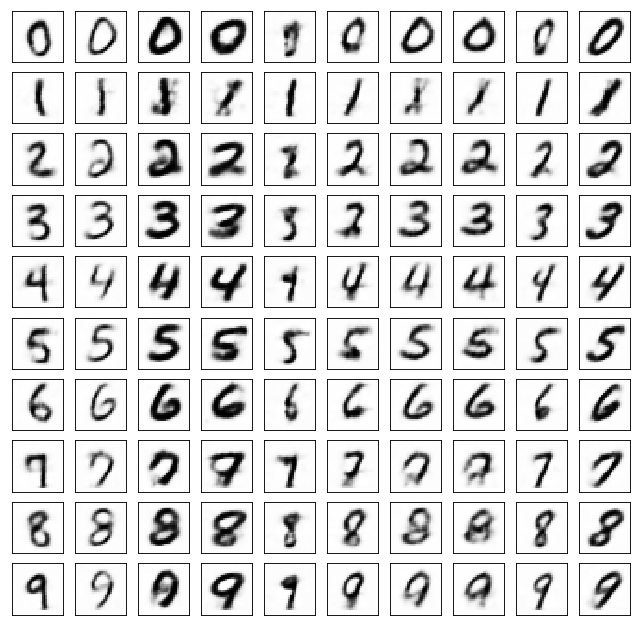

In [25]:
sampled_data = torch.randn((10, 10)) # 10 sampled data points
classes = torch.eye(10) # one-hot encoded label classes

to_plot = []

for i in range(classes.shape[0]):
    for j in range(sampled_data.shape[0]):
        # adding label conditions to sampled data
        concat = torch.cat((sampled_data[j, :], classes[i, :]), 0)
        decoded = models['VAE10_cond'].decode(concat).data.numpy()
        to_plot.append(decoded)

to_plot = np.array(to_plot).reshape(-1, 1, 28, 28)
plot_mnist(to_plot, (10, 10))